In [ ]:
import tensorflow.compat.v1 as tf
tf.enable_eager_execution()
from tensorflow import keras
import numpy as np
import random
import os
import gc
import time
import platform

from sklearn import random_projection

from matplotlib import pyplot as plt
import seaborn as sns

In [ ]:
NUM_CLASSES = 10
WIDTH = 32
NUM_CHANNELS = 3
NUM_TRAIN = 50000
NUM_TEST = 10000
NUM_DEV = 100

DATASET = "cifar10"
BASE_DIR = f""

## Data loading

In [ ]:
def _normalize(X):
  assert X.dtype == np.uint8
  X = X.astype(np.float64)
  X /= 255
  return X

def get_one_hot(targets, nb_classes):
  res = np.eye(nb_classes)[np.array(targets).reshape(-1)]
  return res.reshape(list(targets.shape)+[nb_classes])

def load_standard_cifar10():
  (X_train, Y_train), (X_validation, Y_validation) = tf.keras.datasets.cifar10.load_data()
  X_train = X_train.reshape(X_train.shape[0], WIDTH, WIDTH, NUM_CHANNELS)
  X_validation = X_validation.reshape(X_validation.shape[0], WIDTH, WIDTH, NUM_CHANNELS)

  X_train = _normalize(X_train)
  X_validation = _normalize(X_validation)

  Y_train = Y_train.astype(np.int32)
  Y_validation = Y_validation.astype(np.int32)

  return X_train, Y_train, X_validation, Y_validation

def load_cifar10_train_dev(num_dev=100):
  # randomly select and fixed for future (tracin-like strategy but their indices available only for mnist)
  # selected_dev = np.random.randint(0, X_validation.shape[0], num_dev)
  selected_dev = [5214, 2304, 5947, 9428, 2717, 8296, 7736, 8291, 5235, 54,
                  7499, 9590, 3675, 1932, 6646, 8719, 6484, 6306, 3066, 2442,
                  6106, 1949, 4320,  541, 1318, 5967, 2773, 3847, 1152, 9937,
                  7469, 5982, 7644, 5820, 8152, 9518,  601, 3953, 4931, 1924,
                  5342, 5467, 6718, 6779, 2860, 2440, 5480, 1178,  222, 7909,
                  6394, 3511, 8729, 6261, 7192, 9453, 5257, 9077, 6419, 3280,
                  3725, 3601, 8174, 5703, 4954, 9536, 4783, 2234, 7365, 2405,
                  3073, 2780, 7461, 3525, 7573, 6764, 9962, 7527,  992,  315,
                  6260, 9061,  592, 8003, 7594, 1930, 7215, 5124, 7531, 9471,
                  2824, 3533, 6062, 3946, 5246, 4440,  414, 3572, 4899, 884]
  X_train, Y_train, X_validation, Y_validation = load_standard_cifar10()
  X_dev = X_validation[selected_dev]
  Y_dev = Y_validation[selected_dev]
  return X_train, Y_train, X_dev, Y_dev

In [ ]:
X_train, Y_train, X_dev, Y_dev = load_cifar10_train_dev()

170498071/170498071 [==============================] - 13s 0us/step


## TrackIn

In [ ]:
EPOCHS = 90
BATCH_SIZE = 50

In [ ]:
def deep_model():
  model = tf.keras.Sequential((
      # tf.keras.layers.Flatten(input_shape=(WIDTH, WIDTH), name='input', dtype=np.float64),
      tf.keras.layers.Flatten(input_shape=(WIDTH, WIDTH, NUM_CHANNELS), name='input', dtype=np.float64),
      tf.keras.layers.Dense(256, name='hidden1', activation='relu', dtype=np.double),
      tf.keras.layers.Dense(128, name='hidden2', activation='relu', dtype=np.double),
      tf.keras.layers.Dense(64, name='hidden3', activation='relu', dtype=np.double),
      tf.keras.layers.Dense(32, name='hidden4', activation='relu', dtype=np.double),
      tf.keras.layers.Dense(NUM_CLASSES, name='logits', dtype=np.float64),
      tf.keras.layers.Activation(tf.nn.softmax, name='softmax', dtype=np.float64)))
  return model

deep_model().summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (Flatten)             (None, 3072)              0         
                                                                 
 hidden1 (Dense)             (None, 256)               786688    
                                                                 
 hidden2 (Dense)             (None, 128)               32896     
                                                                 
 hidden3 (Dense)             (None, 64)                8256      
                                                                 
 hidden4 (Dense)             (None, 32)                2080      
                                                                 
 logits (Dense)              (None, 10)                330       
                                                                 
 softmax (Activation)        (None, 10)                0

In [ ]:
# equal to cnn_cifar in biased_hai project, used from a medium article
def deep_model(inp_shape=(32,32,3)):
	model = tf.keras.Sequential()
	model.add(tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=inp_shape, dtype=np.float64))
	model.add(tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', dtype=np.float64))
	model.add(tf.keras.layers.MaxPooling2D((2, 2), dtype=np.float64))
	model.add(tf.keras.layers.Dropout(0.2, dtype=np.float64))
	model.add(tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', dtype=np.float64))
	model.add(tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', dtype=np.float64))
	model.add(tf.keras.layers.MaxPooling2D((2, 2), dtype=np.float64))
	model.add(tf.keras.layers.Dropout(0.2, dtype=np.float64))
	model.add(tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', dtype=np.float64))
	model.add(tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', dtype=np.float64))
	model.add(tf.keras.layers.MaxPooling2D((2, 2), dtype=np.float64))
	model.add(tf.keras.layers.Dropout(0.2, dtype=np.float64))
	model.add(tf.keras.layers.Flatten(dtype=np.float64))
	model.add(tf.keras.layers.Dense(128, activation='relu', kernel_initializer='he_uniform', dtype=np.float64))
	model.add(tf.keras.layers.Dropout(0.2, dtype=np.float64))
	model.add(tf.keras.layers.Dense(10, activation='softmax', dtype=np.float64))
	return model

deep_model().summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 32)        896       
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 32)        9248      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 16, 16, 32)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 16, 16, 64)        18496     
                                                                 
 conv2d_3 (Conv2D)           (None, 16, 16, 64)        36928     
                                                      

In [ ]:
def concat_to_2d(vars_list):
  """expects all elements in list to be 2D and have the same first dim"""
  return tf.concat([tf.reshape(v, (v.shape[0], -1)) for v in vars_list], axis=1)

In [ ]:
def training_loop(X_train, Y_train, X_dev, Y_dev, track_grads=True):
  num_train_examples = X_train.shape[0]
  num_dev_examples = X_dev.shape[0]

  train_dataset = tf.data.Dataset.from_tensor_slices((X_train, Y_train)).take(num_train_examples).batch(BATCH_SIZE, drop_remainder=True)
  dev_dataset = tf.data.Dataset.from_tensor_slices((X_dev, Y_dev)).take(num_dev_examples).batch(BATCH_SIZE, drop_remainder=False)

  training_loss = tf.keras.losses.SparseCategoricalCrossentropy()
  training_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(
      'training_accuracy', dtype=tf.float32)

  model = train_ckpt.model
  step_size = train_ckpt.optimizer.get_config()['learning_rate']
  print(model.summary())

  # --- train and validation ops definition ------
  @tf.function
  def train_step(inputs):
    images, labels = inputs
    with tf.GradientTape(persistent=True) as tape:
      softmax_preds = model(images, training=True)
      loss = training_loss(labels, softmax_preds)

      per_instance_loss = tf.keras.losses.sparse_categorical_crossentropy(labels, softmax_preds) # shape = [BATCH_SIZE]
      tf.assert_equal(tf.rank(per_instance_loss), 1)

    grads = optimizer.get_gradients(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))

    training_accuracy.update_state(labels, softmax_preds)

    if track_grads:
      train_batch_dloss_dweights = concat_to_2d(tape.jacobian(per_instance_loss, model.trainable_variables))
    return loss, train_batch_dloss_dweights

  # @tf.function
  def validation_step():
    with tf.GradientTape(persistent=True) as tape:
      softmax_preds = model(X_dev, training=False)
      per_instance_loss = tf.keras.losses.sparse_categorical_crossentropy(Y_dev, softmax_preds) # shape = [BATCH_SIZE]
    if track_grads:
       test_dloss_dweights = concat_to_2d(tape.jacobian(per_instance_loss, model.trainable_variables))
    return test_dloss_dweights, per_instance_loss

  dev_influences = train_ckpt.dev_loss_influences.numpy()

  # save initial state
  train_steps = train_ckpt.step.numpy()
  train_steps_per_epoch = num_train_examples // BATCH_SIZE
  for epoch in range((train_steps//train_steps_per_epoch)+1, EPOCHS+1):
    loss = 0.0

    batch_influences_list = [] # collection of batches of influences, each item is of shape [num_dev_examples, BATCH_SIZE]
    loss_changes_list = []
    for inputs in train_dataset:
      dev_loss_before = tf.keras.losses.sparse_categorical_crossentropy(Y_dev, model(X_dev, training=False))
      loss, dloss_dweights_batch = train_step(inputs)
      # dloss_dweights_batch = tf.stack(per_instance_dloss_dweights_list)
      dloss_dweights_batch = dloss_dweights_batch*step_size/BATCH_SIZE # accounted for learning rate/step size and reduction here.

      if track_grads:
        # track how loss changed after every train step:
        dev_dloss_dweights_for_train_batch, dev_loss = validation_step()
        batch_influences = np.matmul(dev_dloss_dweights_for_train_batch, np.transpose(dloss_dweights_batch))
        assert batch_influences.shape[0] == num_dev_examples
        assert batch_influences.shape[1] == BATCH_SIZE
        batch_influences_list.append(batch_influences)
        loss_changes_list.append(dev_loss_before - dev_loss)

      train_steps += 1
    #----- end of one epoch training  ---------------------

    if track_grads:
      # end of epoch influences.
      epoch_influences = tf.concat(batch_influences_list, axis=1)
      loss_changes = np.stack(loss_changes_list, axis=1)
      assert epoch_influences.shape[0] == num_dev_examples
      assert epoch_influences.shape[1] == num_train_examples
      dev_influences = epoch_influences
      del(epoch_influences)

    # Save final state.
    # if tf.not_equal(train_steps, train_ckpt.step):
    train_ckpt.step.assign(train_steps)
    train_ckpt.dev_loss_influences.assign(dev_influences)
    train_ckpt.dev_loss_changes.assign(loss_changes)
    save_path = train_ckpt_manager.save()
    print("Epoch last saved checkpoint for step {}: {}".format(int(train_ckpt.step), save_path))
    print('Training steps: ', train_steps, ' loss: ', loss, '; accuracy: ', round(training_accuracy.result().numpy() * 100, 2))
    training_accuracy.reset_states()

    gc.collect() # trigger gc after each epoch

  del(train_dataset)
  del(dev_dataset)
  return model, dev_influences

In [ ]:
TRIAL = 1
NUM_TRAIN = 50000
NUM_DEV = 100

In [ ]:
# optimizer = tf.keras.optimizers.SGD(lr=0.01, momentum=0.0, decay=0.0, nesterov=False)
optimizer = tf.keras.optimizers.Adam()
train_ckpt = tf.train.Checkpoint(
    step=tf.Variable(0),
    optimizer=optimizer,
    model=deep_model(),
    dev_loss_changes = tf.Variable(np.zeros((NUM_DEV,NUM_TRAIN//BATCH_SIZE))),
    dev_loss_influences=tf.Variable(np.zeros((NUM_DEV, NUM_TRAIN))))
train_ckpt_manager = tf.train.CheckpointManager(train_ckpt, BASE_DIR + '/tmp/cifar10/original/{0}/train_ckpts/'.format(TRIAL), max_to_keep=200)
train_ckpt.model.compile(optimizer=optimizer, loss=tf.keras.losses.SparseCategoricalCrossentropy(), metrics=['accuracy'])

In [ ]:
train_ckpt_manager.latest_checkpoint
train_ckpt.restore(train_ckpt_manager.latest_checkpoint)

### Training and getting precise influences

In [ ]:
_, dev_influences = training_loop(X_train, Y_train, X_dev, Y_dev, track_grads=True)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 32, 32, 32)        896       
                                                                 
 conv2d_7 (Conv2D)           (None, 32, 32, 32)        9248      
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 16, 16, 32)       0         
 2D)                                                             
                                                                 
 dropout_4 (Dropout)         (None, 16, 16, 32)        0         
                                                                 
 conv2d_8 (Conv2D)           (None, 16, 16, 64)        18496     
                                                                 
 conv2d_9 (Conv2D)           (None, 16, 16, 64)        36928     
                                                      

Epoch last saved checkpoint for step 12000: drive/MyDrive/Colab Notebooks/SAME/sota/sota_cifar10/tmp/cifar10/original/1/train_ckpts/ckpt-12
Training steps:  12000  loss:  tf.Tensor(0.6980465054512024, shape=(), dtype=float64) ; accuracy:  82.35
Epoch last saved checkpoint for step 13000: drive/MyDrive/Colab Notebooks/SAME/sota/sota_cifar10/tmp/cifar10/original/1/train_ckpts/ckpt-13
Training steps:  13000  loss:  tf.Tensor(0.5295833349227905, shape=(), dtype=float64) ; accuracy:  82.65
Epoch last saved checkpoint for step 14000: drive/MyDrive/Colab Notebooks/SAME/sota/sota_cifar10/tmp/cifar10/original/1/train_ckpts/ckpt-14
Training steps:  14000  loss:  tf.Tensor(0.43920138478279114, shape=(), dtype=float64) ; accuracy:  83.44


### Finding best checkpoint based on performance on entire validation set

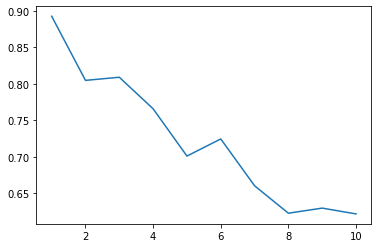

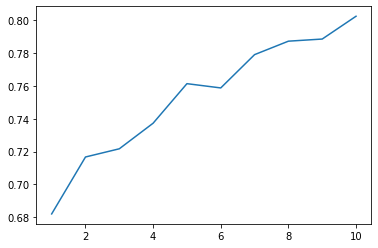

In [ ]:
_, _, X_test, Y_test = load_standard_cifar10()

test_accuracies = []
test_loss = []
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy()
for ckpt_num in range(1, len(train_ckpt_manager.checkpoints)):
  train_ckpt.restore(train_ckpt_manager.checkpoints[ckpt_num])
  P_test = train_ckpt.model(X_test, training=False)
  # test_accuracies.append(len(np.argwhere(Y_test == np.argmax(P_test, axis=1)))/100.)
  # test_accuracies.append(len(np.argwhere(np.squeeze(Y_test) == np.argmax(P_test, axis=1)))/100.)
  test_accuracies.append((np.squeeze(Y_test) == np.argmax(P_test, axis=1)).mean())
  test_loss.append(loss_fn(Y_test, P_test))

sns.lineplot(x=range(1,len(train_ckpt_manager.checkpoints)), y=[x.numpy() for x in test_loss])
plt.figure()
sns.lineplot(x=range(1,len(train_ckpt_manager.checkpoints)), y=[x for x in test_accuracies])

In [ ]:
X_test, Y_test, _, _ = load_standard_cifar10()

test_accuracies = []
test_loss = []
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy()
for ckpt_num in range(1, len(train_ckpt_manager.checkpoints)):
  train_ckpt.restore(train_ckpt_manager.checkpoints[ckpt_num])
  P_test = train_ckpt.model(X_test, training=True)
  # test_accuracies.append(len(np.argwhere(Y_test == np.argmax(P_test, axis=1)))/100.)
  test_accuracies.append((np.squeeze(Y_test) == np.argmax(P_test, axis=1)).mean())
  test_loss.append(loss_fn(Y_test, P_test))

sns.lineplot(x=range(1,len(train_ckpt_manager.checkpoints)), y=[x.numpy() for x in test_loss])
plt.figure()
sns.lineplot(x=range(1,len(train_ckpt_manager.checkpoints)), y=[x for x in test_accuracies])

In [ ]:
# EARLY_STOP_CKPT = 75
EARLY_STOP_CKPT = 11
train_ckpt_manager.checkpoints[EARLY_STOP_CKPT-1]

In [ ]:
train_ckpt.restore(train_ckpt_manager.checkpoints[EARLY_STOP_CKPT-1])
keras.models.save_model(train_ckpt.model, BASE_DIR + '/tmp/cifar10/original/{0}/model_ckpt_25.h5'.format(TRIAL))

## TrackIn is first order approximation of change in loss

In [ ]:
step_influences = []
step_losses = []
for ckpt_num in range(1, EARLY_STOP_CKPT):
  train_ckpt.restore(train_ckpt_manager.checkpoints[ckpt_num])

  for si in range(0, NUM_TRAIN, BATCH_SIZE):
    if ckpt_num == 1 and si == 0:
      print((si,si+BATCH_SIZE), (si//BATCH_SIZE,(si+BATCH_SIZE)//BATCH_SIZE), train_ckpt.dev_loss_changes.numpy()[:,si//BATCH_SIZE:(si+BATCH_SIZE)//BATCH_SIZE].shape)
    step_influences.append(np.sum(train_ckpt.dev_loss_influences.numpy()[:,si:si+BATCH_SIZE], axis=1))
    step_losses.append(np.sum(train_ckpt.dev_loss_changes.numpy()[:,si//BATCH_SIZE:(si+BATCH_SIZE)//BATCH_SIZE], axis=1))

(0, 50) (0, 1) (100, 1)


In [ ]:
len(step_losses), len(step_influences), step_losses[0].shape, step_influences[0].shape, (EARLY_STOP_CKPT-1)*300  # should be 300*(num_ckpts-1)

(24000, 24000, (100,), (100,), 7200)

In [ ]:
np.savez_compressed(BASE_DIR + '/tmp/cifar10/original/{0}/dev_step_loss_deltas.npz'.format(TRIAL), step_losses)
np.savez_compressed(BASE_DIR + '/tmp/cifar10/original/{0}/dev_step_influences.npz'.format(TRIAL), step_influences)

In [ ]:
step_losses = np.reshape(np.load(BASE_DIR + '/tmp/cifar10/original/{0}/dev_step_loss_deltas.npz'.format(TRIAL))['arr_0'], (-1,))
step_influences = np.reshape(np.load(BASE_DIR + '/tmp/cifar10/original/{0}/dev_step_influences.npz'.format(TRIAL))['arr_0'], (-1,))
step_losses.shape, step_influences.shape

((2400000,), (2400000,))

In [ ]:
# trying to take a correlatin of 2M points crashes, so we take a sample to get correlation.
sample = np.random.choice(len(step_losses), len(step_losses)//100, replace=False)
corr_delta_loss_infl = np.corrcoef(step_influences[sample], step_losses[sample])[0,1]
print(corr_delta_loss_infl)

0.9377969299265229


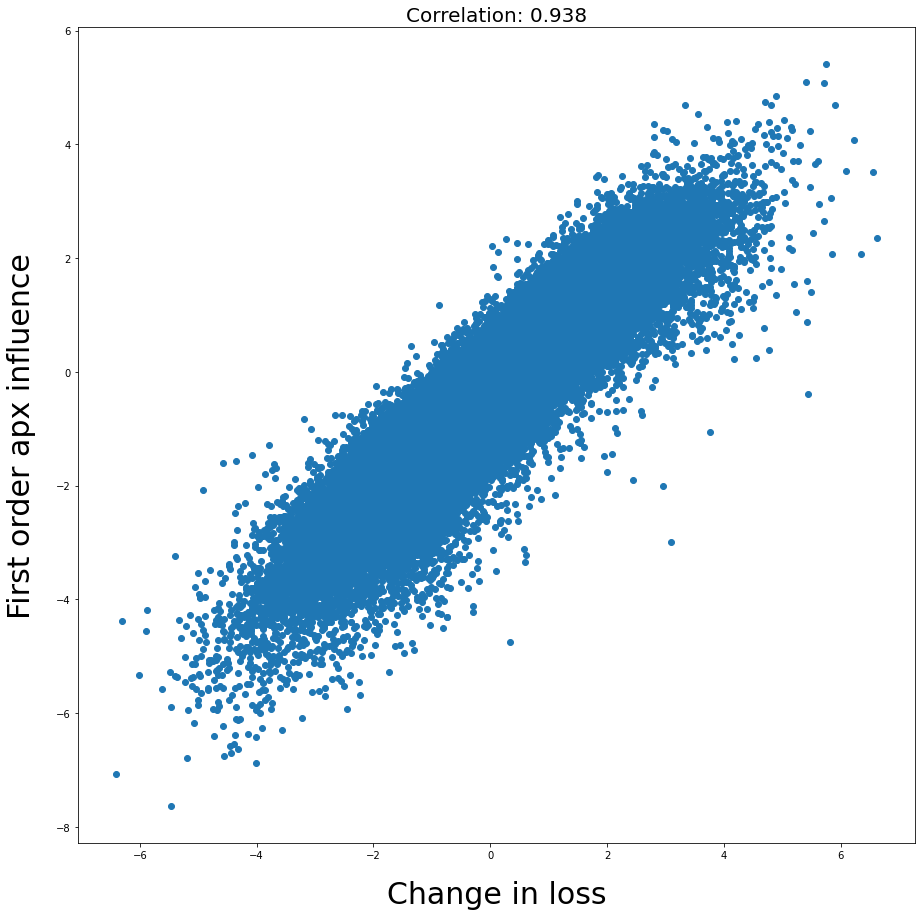

In [ ]:
plt.figure(figsize=(15,15))

plt.scatter(y=step_influences, x=step_losses)
plt.ylabel('First order apx influence', fontsize=30, labelpad=20)
plt.xlabel('Change in loss', fontsize=30, labelpad=20)
plt.title('Correlation: {0:.03f}'.format(corr_delta_loss_infl), fontsize=20)

plt.show()

## Effect of checkpoints and random projections on TrackIn

In [ ]:
# each checkpoint has influences for that epoch, gather those across epochs (until the best checkpoint)
trackin_influences = np.zeros((NUM_DEV, NUM_TRAIN))
for ckpt_num in range(1, EARLY_STOP_CKPT):
  train_ckpt.restore(train_ckpt_manager.checkpoints[ckpt_num])
  trackin_influences += train_ckpt.dev_loss_influences.numpy() # 100, 60000

np.savez_compressed(BASE_DIR + '/tmp/cifar10/original/{0}/trackin_precise_influences.npz'.format(TRIAL), trackin_influences)

In [ ]:
num_parameters = train_ckpt.model.count_params()
projection_sample = np.zeros((10, num_parameters), dtype=np.float64)
proj_list = []
for n_components in [50, 100, 1000]:
  proj = random_projection.GaussianRandomProjection(n_components=n_components)
  proj.fit(projection_sample)
  proj_list.append(proj)
del(projection_sample)

In [ ]:
def get_loss_influences(test_loss_grads, proj_list):
  """Gets influences given test loss gradients"""
  inf_loss = []
  inf_loss_proj={}
  test_loss_grads_proj = {}
  for x in range(len(proj_list)):
    inf_loss_proj[x] = []
    test_loss_grads_proj[x]=np.transpose(proj_list[x].transform(test_loss_grads))

  # K = 500
  K = 100
  for si in range(0, X_train.shape[0], K):
    with tf.GradientTape() as tape:
      pred = train_ckpt.model(X_train[si:si+K], training=False)
      loss = tf.keras.losses.sparse_categorical_crossentropy(Y_train[si:si+K], pred)
    loss_grads = concat_to_2d(tape.jacobian(loss, train_ckpt.model.trainable_variables))
    inf_loss.append(np.matmul(loss_grads, np.transpose(test_loss_grads)))

    for x in range(len(proj_list)):
      proj = proj_list[x]
      inf_loss_proj[x].append(np.matmul(proj.transform(loss_grads), test_loss_grads_proj[x]))
    del(tape)
    if (si%10000) == 0:
      print(si)

  for x in range(len(proj_list)):
    inf_loss_proj[x] = np.transpose(np.concatenate(inf_loss_proj[x]))
  return np.transpose(np.concatenate(inf_loss)), inf_loss_proj


In [ ]:
def get_loss_gradients(X_test, Y_test):
  loss_grads = []
  with tf.GradientTape() as tape:
    pred = train_ckpt.model(X_test, training=False)
    loss = tf.keras.losses.sparse_categorical_crossentropy(Y_test, pred)
  return concat_to_2d(tape.jacobian(loss, train_ckpt.model.trainable_variables))

In [ ]:
loss_influences={}
loss_influences_proj={}

In [ ]:
# for ckpt_num in [4,14,29,44,59,74]:
for ckpt_num in [4,8,12,16,20,24]:
  ckpt_path = train_ckpt_manager.checkpoints[ckpt_num]
  train_ckpt.restore(ckpt_path)
  l, p = get_loss_influences(get_loss_gradients(X_dev, Y_dev), proj_list)
  np.savez_compressed(BASE_DIR + '/tmp/cifar10/original/{0}/trackin_loss_infl_{1}.npz'.format(TRIAL, ckpt_num+1), l)
  np.savez_compressed(BASE_DIR + '/tmp/cifar10/original/{0}/trackin_loss_infl_proj_{1}.npz'.format(TRIAL, ckpt_num+1), p)

0


10000
20000
30000
40000
0
10000
20000
30000
40000
0
10000
20000
30000
40000
0
10000
20000
30000
40000
0
10000
20000
30000
40000
0
10000
20000
30000
40000


In [ ]:
for ckpt_num in [4,8,12,16,20,24]:
  ckpt_path = train_ckpt_manager.checkpoints[ckpt_num]
  train_ckpt.restore(ckpt_path)
  l, _ = get_loss_influences(get_loss_gradients(X_dev, Y_dev), [])
  np.savez_compressed(BASE_DIR + '/tmp/cifar10/original/{0}/trackin_loss_infl_{1}.npz'.format(TRIAL, ckpt_num+1), l)

0


10000
20000
30000
40000
0
10000
20000
30000


ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py", line 3326, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-28-ca7cb0662ca1>", line 9, in <module>
    l, _ = get_loss_influences(get_loss_gradients(X_dev, Y_dev), [])
  File "<ipython-input-25-f286943793ed>", line 16, in get_loss_influences
    loss_grads = concat_to_2d(tape.jacobian(loss, train_ckpt.model.trainable_variables))
  File "/usr/local/lib/python3.7/dist-packages/tensorflow/python/eager/backprop.py", line 1183, in jacobian
    parallel_iterations=parallel_iterations)
  File "/usr/local/lib/python3.7/dist-packages/tensorflow/python/ops/parallel_for/control_flow_ops.py", line 202, in pfor
    outputs = f()
  File "/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/traceback_utils.py", line 150, in error_handler
    return fn(*args, **kwargs)
  File "/usr/local/lib/python3.7/dist-packages/tensorflow/python/eager

KeyboardInterrupt: ignored

In [ ]:
accum_influences = np.zeros((100, 60000))
accum_influences_proj = {}
for x in range(len(proj_list)):
  accum_influences_proj[x] = np.zeros((100, 60000))
for ckpt_num in [4, 14, 29, 44, 59, 74]:
  accum_influences += np.load(BASE_DIR + '/tmp/mnist/original/{0}/trackin_loss_infl_{1}.npz'.format(TRIAL, ckpt_num+1))['arr_0']
  for x in range(len(proj_list)):
    accum_influences_proj[x] += np.load(BASE_DIR + '/tmp/mnist/original/{0}/trackin_loss_infl_proj_{1}.npz'.format(TRIAL, ckpt_num+1), allow_pickle=True, encoding='bytes')['arr_0'].tolist()[x]
accum_6 = np.array([np.corrcoef(accum_influences[i], trackin_influences[i])[0,1] for i in range(100)])

accum_proj_6={}
for x in range(len(proj_list)):
  accum_proj_6[x] = np.array([np.corrcoef(accum_influences_proj[x][i], trackin_influences[i])[0,1] for i in range(100)])

In [ ]:
accum_influences = np.zeros((100, 60000))
for ckpt_num in [4, 24, 44, 64]:
  accum_influences += np.load(BASE_DIR + '/tmp/mnist/original/{0}/trackin_loss_infl_{1}.npz'.format(TRIAL, ckpt_num+1))['arr_0']
accum_4 = np.array([np.corrcoef(accum_influences[i], trackin_influences[i])[0,1] for i in range(100)])

accum_influences = np.zeros((100, 60000))
for ckpt_num in [24, 49, 74]:
  accum_influences += np.load(BASE_DIR + '/tmp/mnist/original/{0}/trackin_loss_infl_{1}.npz'.format(TRIAL, ckpt_num+1))['arr_0']
accum_3 = np.array([np.corrcoef(accum_influences[i], trackin_influences[i])[0,1] for i in range(100)])

accum_influences = np.zeros((100, 60000))
for ckpt_num in [4, 14, 24]:
  accum_influences += np.load(BASE_DIR + '/tmp/mnist/original/{0}/trackin_loss_infl_{1}.npz'.format(TRIAL, ckpt_num+1))['arr_0']
accum_3_high_loss = np.array([np.corrcoef(accum_influences[i], trackin_influences[i])[0,1] for i in range(100)])

ckpt_35 = np.array([np.corrcoef(np.load(BASE_DIR + '/tmp/mnist/original/{0}/trackin_loss_infl_{1}.npz'.format(TRIAL, 35))['arr_0'][i], trackin_influences[i])[0,1] for i in range(100)])

# some gradients towards the end are zero, adding an epsilon to get around nan issue with correlation results.
ckpt_75 = np.array([np.corrcoef(1000*np.load(BASE_DIR + '/tmp/mnist/original/{0}/trackin_loss_infl_{1}.npz'.format(TRIAL, 75))['arr_0'][i] + 0.000001, 1000*trackin_influences[i]+ 0.000001)[0,1] for i in range(100)])

(array([-0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ]),
 <a list of 7 Text major ticklabel objects>)

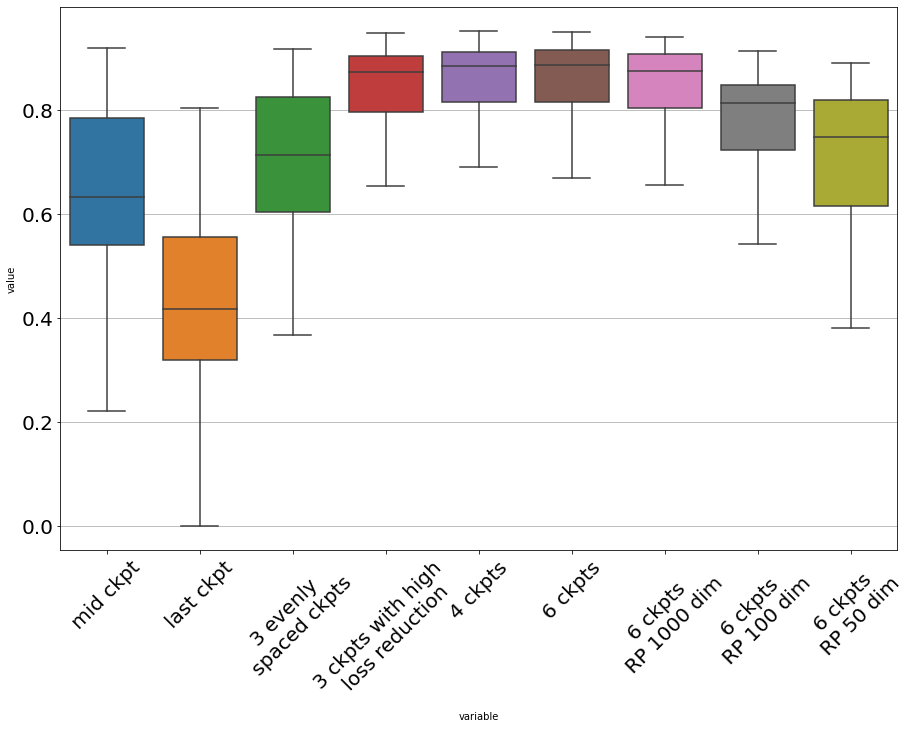

In [ ]:
cors = [ckpt_35,
        ckpt_75,
        accum_3,
        accum_3_high_loss,
        accum_4,
        accum_6,
        accum_proj_6[2],
        accum_proj_6[1],
        accum_proj_6[0]]

plt.figure(figsize=(15,10))
# plot = sns.boxplot(y=np.array(cors).T, x=['mid ckpt', 'last ckpt', '3 evenly\n spaced ckpts', '3 ckpts with high\n loss reduction', '4 ckpts', '6 ckpts', '6 ckpts\n RP 1000 dim', '6 ckpts\n RP 100 dim', '6 ckpts\n RP 50 dim'], showfliers=False)
###
import pandas as pd
df_cors = pd.DataFrame(np.array(cors).T, columns=['mid ckpt', 'last ckpt', '3 evenly\n spaced ckpts', '3 ckpts with high\n loss reduction', '4 ckpts', '6 ckpts', '6 ckpts\n RP 1000 dim', '6 ckpts\n RP 100 dim', '6 ckpts\n RP 50 dim'])
plot = sns.boxplot(x="variable", y="value", data=pd.melt(df_cors), showfliers=False)
###
plot.set_xticklabels(plot.get_xticklabels(), rotation=45, fontsize=20)
plt.grid(b=True, axis='y')
plot.set_axisbelow(True)
plt.yticks(fontsize=20)

In [ ]:
[np.median(x) for x in cors]

[0.6318527656556543,
 0.41564721840869756,
 0.7134559164701725,
 0.8726101513524385,
 0.8831877741841803,
 0.8857648247995555,
 0.8749910519333707,
 0.812372885053418,
 0.7473389833072344]